In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
#sys.path.append('C:/Users/Fabian/gempy')
sys.path.insert(1,'/home/fabian/gempy')
import gempy as gp

In [3]:
%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

#import vtk
#import evtk

from scipy.interpolate import griddata

In [4]:
import gempy.utils.spill_analysis as sp
import gempy.utils.fault_analysis as fa
import gempy.utils.decision_making as dm

In [5]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_o = ".././input_data/Fab_ResModel_Foliations2.csv",
                        path_i = ".././input_data/Fab_ResModel_Points4_small_offset.csv")
                         #path_i = ".././input_data/Fab_ResModel_finite_fault.csv")
geo_data.n_faults = 1

In [6]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

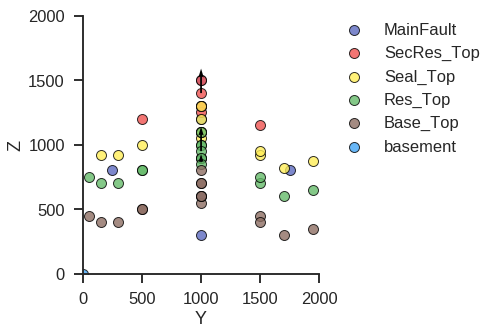

In [7]:
figsize(20,10)
#plt.savefig('points.pdf', transparent=True)
gp.plotting.plot_data(geo_data, direction='x')

In [8]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
def set_fault_sides(geo_data, fault_border, fault_name):
    geo_data.interfaces['fault side'] = 'nan'
    HW_border = fault_border # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    nonfault_cond = geo_data.interfaces['formation'] != fault_name
    fault_cond = geo_data.interfaces['formation'] == fault_name

    fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

    hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

    geo_data.interfaces.loc[fw_x_cond,'fault side'] = 'footwall' # setting FW
    geo_data.interfaces.loc[hw_x_cond,'fault side'] = 'hanging wall' #setting HW
    geo_data.interfaces.loc[fault_cond,'fault side'] = 'nan'; # reverting fault points to 'nan'
    return geo_data

In [9]:
geo_data = set_fault_sides(geo_data, 1300, 'MainFault')

In [10]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, u_grade = [1, 1], output='gradients',
                                 compile_theano=True, dtype ='float64', theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1


In [11]:
#interp_data.interpolator.tg.inf_factor.set_value(np.zeros(7, dtype='int32'))
#interp_data.interpolator.tg.inf_factor.get_value()

In [12]:
type(interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].values)

numpy.ndarray

In [13]:
import pandas as pd

In [14]:

# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [15]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

#lith_block = np.round(lith_sol[0]).reshape(geo_data.resolution[0],
#                                     geo_data.resolution[1],geo_data.resolution[2])
#
##fault_block = fault_sol[0].astype(int).reshape(geo_data.resolution[0],
##                                     geo_data.resolution[1],geo_data.resolution[2])
#fault_block_0 = np.round(fault_sol[0])#.astype(int)
#fault_block = fault_block_0.reshape(geo_data.resolution[0],
#                                     geo_data.resolution[1],geo_data.resolution[2])

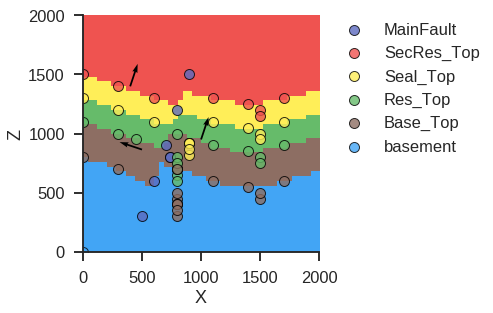

In [16]:
gp.plotting.plot_section(geo_data, lith_sol[0], 25, plot_data=True)

In [17]:
# Geo formation numbers
base_n = geo_data.formations.loc['basement','formation_number']
res_n = geo_data.formations.loc['Base_Top','formation_number']
seal_n = geo_data.formations.loc['Res_Top','formation_number']
secres_n = geo_data.formations.loc['Seal_Top','formation_number']
over_n = geo_data.formations.loc['SecRes_Top','formation_number']
fault_n = geo_data.formations.loc['MainFault','formation_number']

In [18]:
# CREATING SURFACES FOR LAYER INTERFACES (vertices and simplices; interfaces named as bottoms of layers)
res_surf_v, res_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                         potential_fault=None, n_formation = res_n-1)
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = seal_n-1)
secres_surf_v, secres_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                               potential_fault=None, n_formation = secres_n-1)
over_surf_v, over_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = over_n-1)

fault_surf_v, fault_surf_s = gp.get_surfaces(interp_data = 
                                             interp_data, potential_lith=None, potential_fault=fault_sol[1], 
                                             n_formation = fault_n-1)

In [19]:
fault_plot = fa.PlotFault2D(geo_data)

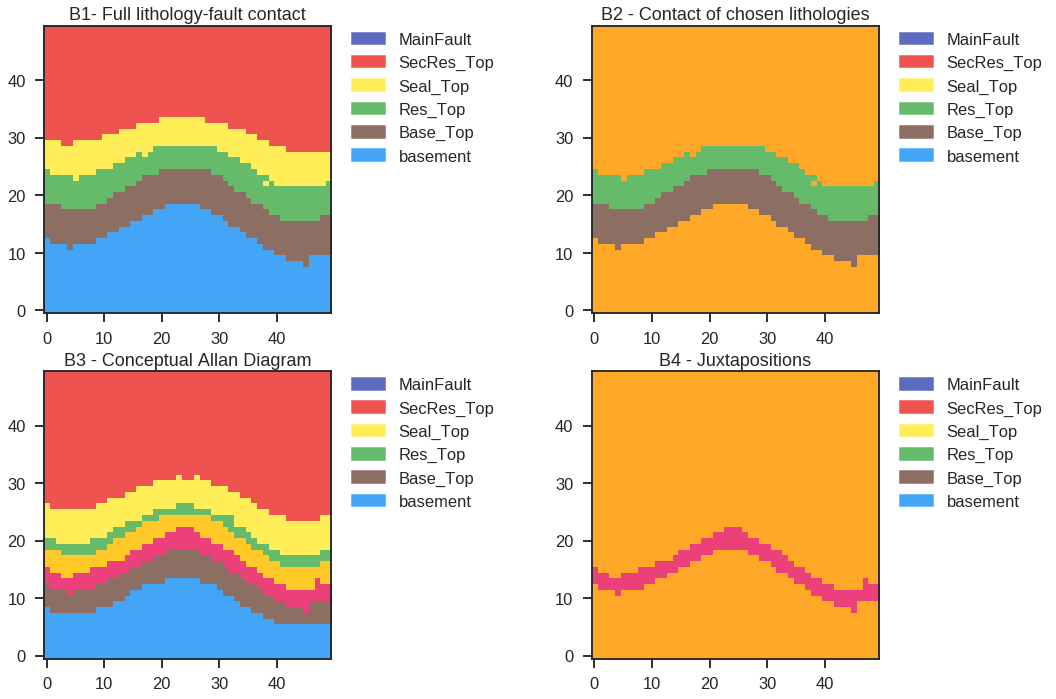

In [20]:
figsize(18,18)

plt.subplot(321)
plt.title('B1- Full lithology-fault contact')
fault_plot.plot_lith_fault_contact_full(lith_sol, fault_sol, fault_n, fault_side='footwall')

plt.subplot(322)
plt.title('B2 - Contact of chosen lithologies')
fault_plot.plot_lith_fault_contact(lith_sol, fault_sol, fault_n, lith_n=[seal_n, res_n], fault_side='footwall')

plt.subplot(323)
plt.title('B3 - Conceptual Allan Diagram')
fault_plot.plot_AllanDiagram(lith_sol, fault_sol, fault_n, lith_target=[res_n], lith_jux=[res_n], target_side='fw')

plt.subplot(324)
plt.title('B4 - Juxtapositions')
fault_plot.plot_juxtapositions(lith_sol, fault_sol, fault_n, lith_target=[res_n], lith_jux=[res_n], target_side='fw');

In [21]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, [res_surf_v, seal_surf_v, secres_surf_v, over_surf_v], 
                    [res_surf_s, seal_surf_s, secres_surf_s, over_surf_s], plot_data=True
                   )

In [22]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 3

permeable_l = [secres_n, over_n]

In [23]:
vox_size_x = np.abs(geo_data.extent[1] - geo_data.extent[0]) / geo_data.resolution[0]
vox_size_y = np.abs(geo_data.extent[3] - geo_data.extent[2]) / geo_data.resolution[1]
vox_size_z = np.abs(geo_data.extent[5] - geo_data.extent[4]) / geo_data.resolution[2]
vox_size_diag = np.sqrt(vox_size_x ** 2 + vox_size_y ** 2 + vox_size_z ** 2)

In [24]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
#gp.plotting.plot_section(geo_data, lith_block, int(resolution/2), plot_data=1, direction='y')
#plt.savefig('computed_block.pdf', transparent=True)

In [25]:
GX,GY,GZ=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution), lith_sol[4].reshape(resolution,resolution,resolution)

In [26]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith, fault, bottom_z, formation_bool, fault_bool):
    mask = np.ones_like(lith)
    mask[~formation_bool] = False
    mask[fault_bool] = False
    #mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5).astype(int) #rounding up to avoid voxel connection to outside borders
    mask = mask.reshape(resolution,resolution,resolution)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(geo_data, lith, fault, seal_th, trap_n):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
        gp.topology.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 0)
    trap_keys = [int(k) for k in lith_to_labels_lot["%s" % trap_n].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["0"].keys()] # model border sections
    base_keys = [int(b) for b in lith_to_labels_lot["%s" % base_n].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_n].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_n].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_n].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    #gp.topology.classify_edges(G, centroids, lith.reshape(resolution,resolution,resolution), fault.reshape(resolution,resolution,resolution))   
    gp.topology.classify_edges(G, centroids, lith_pad, fault_pad)   
    # If too many traps, model probably broken:
    print("NUMBER OF POTENTIAL TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        print('Too many traps detected. Reservoir discontinuous or model probably broken.')
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology.check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                traps.append(tk)
                print('TRAP CONFIRMED:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask # this mask returns True for all voxels which were accepted as trap voxels

In [27]:
# get juxtaposition with itself
def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n):
    hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
    maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
    if np.any(maxline_hw):
        max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z
        return max_jux
    else:
        return 0

#def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
#                        res_n):
#    juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
#                        lith_target=res_n, lith_jux=res_n, target_side='fw', projection='automatic')
#    if np.any(juxta):
#        max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
#        return max_jux
#    else:
#        return 0

In [28]:
#hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
#maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
#if np.any(maxline_hw):
#    max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z

In [29]:
# get juxtapositions with any other input perm layers
def perm_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, lith_perm):
    if isinstance(lith_perm, int):
        lith_perm = [lith_perm]
    juxta_list = np.zeros((len(lith_perm),2))
    juxta_list[:,0] = np.array(lith_perm)
    for i in lith_perm:
        juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, i, target_side='fw', projection='automatic')
        if np.any(juxta):
            max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
            juxta_list[(np.argwhere(juxta_list[:,0]==i)),1] = max_jux
    juxta_list = np.delete(juxta_list, np.argwhere(juxta_list[:,1]==0), 0)
    return juxta_list        

In [30]:
# get SSF on base of fault analysis module
def fa_SSF(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position='faultmax_argrelmax', order=40):
    fault_throws = fa.get_faultthrow_at(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position=position, order=order, artifact_filter='on')
    max_throw = np.nanmax(fault_throws)
    contact = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw')
    proj = fa.project_voxels(contact, form='2D')
    lith_thickness = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw',
                      position=position, order=order)
    min_thickness = np.nanmin(lith_thickness)
    SSF = max_throw/min_thickness
    print('SSF = %s / %s = %s' % (max_throw, min_thickness, SSF))
    return SSF

In [54]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps
def max_trap_vol(geo_data, interp_data, lith_sol, fault_sol, res_n, seal_n, fault_n, GX, GY, seal_surf_v):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    trap_n = (np.max(formation_numbers)+1)
    
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]
    
    seal_thickness_all = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, 
                                                 seal_n, fault_n, fault_side='fw',
                      position='faultmax_argrelmax', order=40)
    seal_thickness = np.nanmin(seal_thickness_all)
    
    seal_thresh = vox_size_z
    if seal_thickness < seal_thresh:
        print("Seal layer compromised, too thin.")
        print('CONTROL: STRAT. SEAL BREACH')
        # Trap failed due to assumed seal cap discontinuity: return no volume, no trap, SSF = nan
        return 0, np.zeros_like(lith_block), np.nan, 4    

    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear
                        # 1 = Spill Point
                        # 2 = Leak Point (LEAK UNDER)
                        # 3 = Seal breach juxtaposition leakage (LEAK OVER)
                        # 4 = Stratigraphical adjacency leakage 
    highest_spill_point = sp.get_highest_saddle_point(geo_data, seal_surf_v, GX, GY)
    
    if highest_spill_point == []:
        spill_z = np.nan
        print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith_block)
        return trap_vol, final_trap_mask, np.nan, 0
    
    spill_z = np.max(highest_spill_point[2])
    leak_self_z = self_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n)
    # need to implement variability of permeable layers
    juxta_above = perm_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n, lith_perm=permeable_l)
    
    print('SPILL POINT COORDINATES:', highest_spill_point)
    print('LEAK SELF Z-POSITION:', leak_self_z)
    print('JUXTA with permable layers:', juxta_above)

    SSF_c = 3
    SSF = fa_SSF(geo_data, lith_sol, fault_sol, seal_n, fault_n,
                      position='faultmax_argrelmax', order=40)
    if SSF > SSF_c:
        print('SSF threshold exceeded, shale smear assumed to be incomplete.')
        SSF_sealing = False
    else: 
        print('SSF in confidence range, complete shale smear sealing assumed.')
        SSF_sealing = True
        
    #general_sealing = False # might be implemented later (as binomial probability)
    
    if juxta_above.size == 0:
        leak_z = leak_self_z
        # no SSF necessary (but still have to be calculated if relevant in probabilistic model)
        # possible use of general fault sealing probability
        max_z = np.nanmax([spill_z, leak_z])  
        if max_z == spill_z:
            trap_control = 1
            print('CONTROL: SPILL Z')
        else:
            trap_control = 2
            print('CONTROL: LEAK Z')
    else:
        # check for SSF/general sealing
        if SSF_sealing == False: 
            leak_above_z = np.max(juxta_above[:,1])
            max_z = np.nanmax([spill_z, leak_above_z]) 
            if max_z == spill_z:
                trap_control = 1
                print('CONTROL: SPILL Z')
            else:
                trap_control = 3
                print('CONTROL: PERM. JUXTA Z')
        #elif general_sealing == False:
        #    max_z = np.nanmax([spill_z, leak_self_z])
        #    if max_z == spill_z:
        #        trap_control = 1
        #    else:
        #        trap_control = 2   
        else:
            max_z = spill_z
            trap_control = 1
            print('CONTROL: SPILL Z')
            
    ### MAKE AN OWN FUNCTION TO GET MAX_Z!              
        
    rounded_lith = np.around(lith_block).astype(int)
    rounded_fault = np.around(fault_block).astype(int)
    res_n_bool = rounded_lith == res_n
    fault_bool = rounded_lith == 2
        
    pre_trap_mask = res_mask(lith_block, fault_block, max_z, res_n_bool, fault_bool)
          
    # volume cells for counting
    vol_cells = 0
    lith_copy = np.copy(lith_block)
        
    pre_trap_mask_bool = (pre_trap_mask == True)
    # Check if there is anything in the reservoir mask at all
    if np.count_nonzero(pre_trap_mask_bool) == 0:
        print("No res_formation above max_z!")
        #trap_control = 0
        return 0, pre_trap_mask, SSF, trap_control
    else:
        lith_copy[pre_trap_mask_bool] = trap_n                           # setting reservoir above bottom on footwall side 
        final_trap_mask = topo_analysis(geo_data, lith_copy, fault_block, seal_thickness, trap_n)
        lith_copy[final_trap_mask] = (trap_n + 1)                        # setting final trap to formation value = trap_n + 1
        vol_cells = np.count_nonzero(final_trap_mask)
            
        #calulate volume from cells
        trap_vol = ((scale_factor)**3) * vol_cells 
        # revert to lith_block without any masks
        #lith[pre_trap_mask_bool] = res_n      
        #return the maximum reservoir volume
        return trap_vol, final_trap_mask, SSF, trap_control

In [55]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

### Setting up the probabilistic model

In [56]:
lith_unc_stds = np.array([40,60,80,100])
# NEXT: create a Z modifier through which we can loop

In [57]:
str(lith_unc_stds)

'[ 40  60  80 100]'

In [58]:
lith_ids = geo_data.interfaces["formation"].dropna().unique()[1:-1]
print(lith_ids)

[SecRes_Top, Seal_Top, Res_Top, Base_Top]
Categories (6, object): [MainFault, SecRes_Top, Seal_Top, Res_Top, Base_Top, basement]


In [59]:
lith_numbers = geo_data.formations.formation_number[1:]

In [60]:
lith_Z_modifier = []

for liID, stdi in zip(lith_ids, lith_unc_stds):
    stoch = pymc.Normal(liID+'_stoch', 0, 1./np.square(stdi/rescale_f))
    lith_Z_modifier.append(stoch)

In [61]:
faultside_ids = geo_data.interfaces["fault side"].dropna().unique()
print(faultside_ids)

['nan' 'hanging wall' 'footwall']


In [62]:
std_offset = 150
fault_Z_modifier = pymc.SkewNormal(faultside_ids[1]+'offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

/home/fabian/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


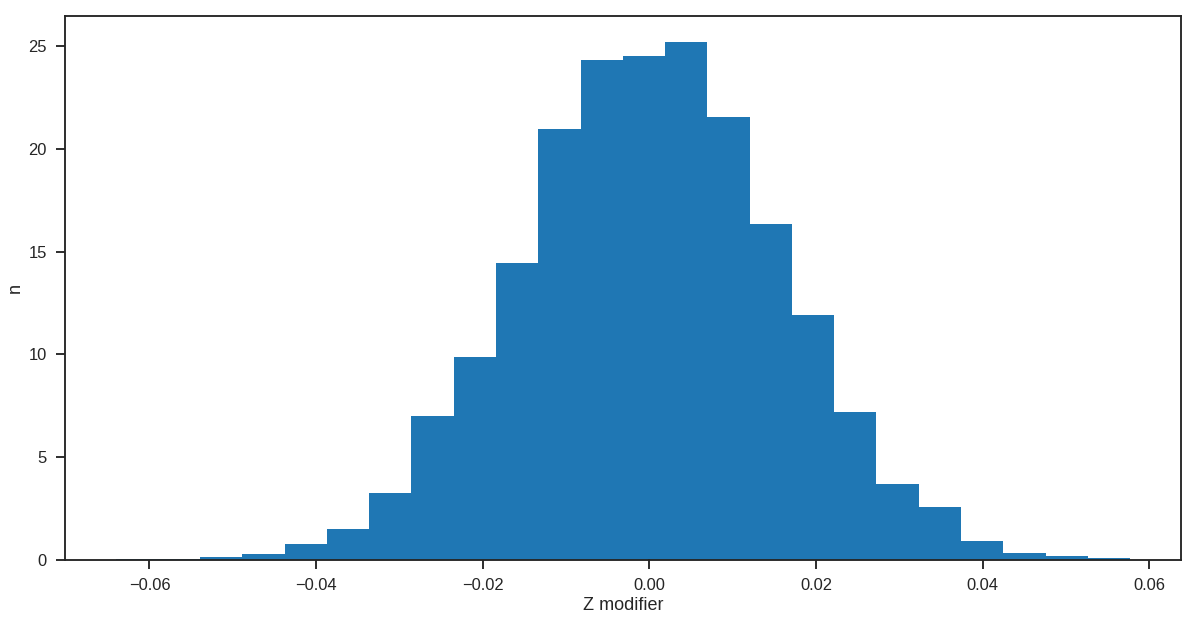

In [63]:
# sample from a distribution
samples = [lith_Z_modifier[1].rand() for i in range(10000)]
# plot histogram
plt.hist(samples, bins=24, normed=True);
plt.xlabel("Z modifier")
plt.vlines(0, 0, 0.01)
plt.ylabel("n");

In [64]:
import copy
geo_data_stoch_init = copy.deepcopy(interp_data.geo_data_res)
#interp_data_stoch_init = copy.deepcopy(interp_data)

In [65]:
# NEW INTERP FUNCTION
@pymc.deterministic(trace=True)
def input_data(value=0, geo_data_stoch_init=geo_data_stoch_init, lith_Z_modifier=lith_Z_modifier, 
              fault_Z_modifier=fault_Z_modifier, verbose= 0):
    
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    
    for e, foID in enumerate(lith_ids):
        # First we obtain a boolean array with trues where the id coincide
        sel = gp.get_data(interp_data.geo_data_res, verbosity=2)['formation'] == foID
        
        # We add to the original Z value (its mean) the stochastic bit in the correspondant groups id 
        geo_data_stoch.loc[sel, 'Z']  += np.array(lith_Z_modifier[e])
        
    sel_fa = gp.get_data(interp_data.geo_data_res, verbosity=2)['fault side'] == 'hanging wall'
    geo_data_stoch.loc[sel_fa, 'Z']  += np.array(fault_Z_modifier)
    
    if verbose > 0:
        print(geo_data_stoch)
    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

In [66]:
@pymc.deterministic(trace=False)
def gempy_model(value=0, input_data=input_data, seal_n=seal_n, print_figures=False):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
    try:
        # try to compute model
        ls, fs = gp.compute_model(interp_data)
        if print_figures:
            gp.plot_section(geo_data, ls[0], np.int(resolution/2), plot_data=True)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return ls, fs, interp_data
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_sol), np.zeros_like(fault_sol), interp_data

In [67]:
@pymc.deterministic(trace=True)
def trap_analysis(value=0, lith_sol=gempy_model[0], fault_sol=gempy_model[1], 
                  interp_data=gempy_model[2], print_figures=False, verbose = False):
    
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    try:
        max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
        return max_vol, SSF, trap_control
    
    except (IndexError, ValueError):
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose == True:
            print("Exception occured.")
        return np.nan, np.nan, np.nan
#@pymc.deterministic(trace=True)
#def trap_analysis(value=0, input_data=input_data, print_figures=False):
#    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
#    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
#                                           'dip', 'azimuth', 'polarity']] = input_data[1]
#    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)    
#    try:
#        # try to compute model
#        lith_sol, fault_sol = gp.compute_model(interp_data)
#        if print_figures:
#            gp.plot_section(interp_data.geo_data_res, lith_sol[0], np.int(resolution/2), plot_data=True)
#           # gp.plot_data(interp_data.geo_data_res, direction='y')
#    
#    except np.linalg.linalg.LinAlgError as err:
#        # if it fails (e.g. some input data combinations could lead to 
#        # a singular matrix and thus break the chain) return an empty model
#        # with same dimensions (just zeros)
#        if verbose:
#            print("Exception occured.")
#        return np.nan, np.nan, np.nan
#    
#    seal_surf_V = gp.get_surfaces(\
#        interp_data = interp_data, potential_lith=lith_sol[1], \
#        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
#    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
#    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
#                                                    lith_sol, fault_sol, res_n, 
#                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
#    print("Maximum trap volume: %s m³" % max_vol)
#    if print_figures:
#        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
#    return max_vol, SSF, trap_control

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          595.26119232]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 480.0 / 280.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 10
TRAP CONFIRMED: 10
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 18
Maximum trap volume: 19136000.0 m³


In [68]:
def trap_analysis_post(lith_sol, fault_sol, print_figures=False):
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]  
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
    print("Maximum trap volume: %s m³" % max_vol)
    if print_figures:
        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
    return max_vol, SSF, trap_control # trap --> what to do about trap return?

In [69]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

In [70]:
# Reservoir thickness
@pymc.deterministic(trace=True)
def thicknesses(value=0, input_data=input_data):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    res_th = np.abs(fw_sb_z-fw_rb_z)
    seal_th = np.abs(fw_r2b_z-fw_sb_z)
    secres_th = np.abs(fw_ob_z-fw_r2b_z) 
    return res_th, seal_th, secres_th

#Seal thickness
#@pymc.deterministic(trace=True)
#def seal_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_r2b_z-fw_sb_z)
#
## Secondary reservoir thickness
#@pymc.deterministic(trace=True)
#def sec_res_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_ob_z-fw_r2b_z) 

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [71]:
iterations = 150

In [72]:
params = [input_data, thicknesses, gempy_model, trap_analysis, *lith_Z_modifier, fault_Z_modifier]
model = pymc.Model(params)
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [73]:
dbname="trapmodel_lithSIMPLEMC"+str(lith_unc_stds)+"_offset"+str(std_offset)+"_"+str(iterations)+"iterations"+".hdf5"

In [74]:
RUN = pymc.MCMC(model, db="hdf5", dbname=dbname)
#RUN = pymc.MCMC(model)

In [75]:
RUN.sample(iter=iterations)

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          742.30949402]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 24384000.0 m³
 [                  1%                  ] 2 of 150 complete in 3.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          612.65274048]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 640.0 / 320.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 26
Maximum trap volume: 24128000.0 m³
 [                  2%                  ] 3 of 150 complete in 6.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          625.95554352]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 240.0 / 400.0 = 0.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 21
Maximum trap volume: 28864000.0 m³
 [-                 2%                  ] 4 of 150 complete in 9.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         655.6136322]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 840.]]
SSF = 600.0 / 240.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 23
Maximum trap volume: 23808000.0 m³
 [-                 3%                  ] 5 of 150 complete in 12.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          776.72325134]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 20800000.0 m³
 [-                 4%                  ] 6 of 150 complete in 15.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          754.70802307]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 27904000.0 m³
 [-                 4%                  ] 7 of 150 complete in 18.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          621.99504852]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: []
SSF = 680.0 / 320.0 = 2.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 24
Maximum trap volume: 18880000.0 m³
 [--                5%                  ] 8 of 150 complete in 21.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          625.66497803]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 520.0 / 280.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 28224000.0 m³
 [--                6%                  ] 9 of 150 complete in 25.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          589.64763641]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 160.0 / 320.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 2944000.0 m³
 [--                6%                  ] 10 of 150 complete in 28.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          656.47888184]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 280.0 / 400.0 = 0.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 26
Maximum trap volume: 23680000.0 m³
 [--                7%                  ] 11 of 150 complete in 31.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          627.27947235]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 760.0 / 400.0 = 1.9
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 27
Maximum trap volume: 28928000.0 m³
 [---               8%                  ] 12 of 150 complete in 34.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          730.46615601]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 80.0 / 240.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 576000.0 m³
 [---               8%                  ] 13 of 150 complete in 37.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.         920.         609.9079895]
LEAK SELF Z-POSITION: 320.0
JUXTA with permable layers: []
SSF = 840.0 / 400.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 33
Maximum trap volume: 23296000.0 m³
 [---               9%                  ] 14 of 150 complete in 40.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         623.6183548]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 520.0 / 280.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 22
Maximum trap volume: 27968000.0 m³
 [---              10%                  ] 15 of 150 complete in 43.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          732.58529663]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 20416000.0 m³
 [----             10%                  ] 16 of 150 complete in 46.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          581.72008514]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 360.0 / 360.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 29
Maximum trap volume: 26752000.0 m³
 [----             11%                  ] 17 of 150 complete in 49.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          728.57673645]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 280.0 / 240.0 = 1.1666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 23
Maximum trap volume: 19648000.0 m³
 [----             12%                  ] 18 of 150 complete in 52.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          697.40364075]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 22016000.0 m³
 [----             12%                  ] 19 of 150 complete in 55.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          745.33622742]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: [[  3. 920.]
 [  2. 920.]]
SSF = 600.0 / 160.0 = 3.75
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 20 of 150 complete in 58.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            14%                  ] 21 of 150 complete in 60.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          763.26164246]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 17216000.0 m³
 [-----            14%                  ] 22 of 150 complete in 63.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          585.13507843]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 80.0 / 320.0 = 0.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 2560000.0 m³
 [-----            15%                  ] 23 of 150 complete in 66.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          561.29570007]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 80.0 / 440.0 = 0.18181818181818182
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 1152000.0 m³
 [------           16%                  ] 24 of 150 complete in 69.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          561.68182373]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 480.0 / 320.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 10
TRAP CONFIRMED: 10
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 11072000.0 m³
 [------           16%                  ] 25 of 150 complete in 72.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          706.90612793]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 560.0 / 280.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 24
Maximum trap volume: 26752000.0 m³
 [------           17%                  ] 26 of 150 complete in 75.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          920.          469.49562073]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 320.0 / 440.0 = 0.7272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
Checking Section: 17
Maximum trap volume: 128000.0 m³
 [------           18%                  ] 27 of 150 complete in 78.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          709.78462219]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 240.0 / 320.0 = 0.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 19
Maximum trap volume: 27008000.0 m³
 [-------          18%                  ] 28 of 150 complete in 81.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          651.07208252]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 200.0 / 360.0 = 0.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 11456000.0 m³
 [-------          19%                  ] 29 of 150 complete in 84.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          633.76544952]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 600.0 / 360.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 31424000.0 m³
 [-------          20%                  ] 30 of 150 complete in 87.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          738.94927979]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 520.0 / 200.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 29
Maximum trap volume: 23168000.0 m³
 [-------          20%                  ] 31 of 150 complete in 90.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.         960.         554.1884613]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: []
SSF = 720.0 / 440.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 26
Maximum trap volume: 26752000.0 m³
 [--------         21%                  ] 32 of 150 complete in 93.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         781.8888855]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 22400000.0 m³
 [--------         22%                  ] 33 of 150 complete in 96.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1400.          920.          687.95158386]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 680.0 / 280.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 25
Maximum trap volume: 20800000.0 m³
 [--------         22%                  ] 34 of 150 complete in 99.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         601.5348053]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 240.0 / 360.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 20352000.0 m³
 [--------         23%                  ] 35 of 150 complete in 102.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          721.68579102]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 840.]]
SSF = 520.0 / 200.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 25
Maximum trap volume: 17344000.0 m³
 [---------        24%                  ] 36 of 150 complete in 106.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1320.          920.          573.50597382]
LEAK SELF Z-POSITION: 360.0
JUXTA with permable layers: [[  3. 760.]]
SSF = 760.0 / 360.0 = 2.111111111111111
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 28
Maximum trap volume: 15808000.0 m³
 [---------        24%                  ] 37 of 150 complete in 108.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          809.50614929]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[   3.  920.]
 [   2. 1000.]]
SSF = 640.0 / 160.0 = 4.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 38 of 150 complete in 111.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          808.49868774]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 520.0 / 240.0 = 2.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 17472000.0 m³
 [---------        26%                  ] 39 of 150 complete in 115.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          735.97221375]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 560.0 / 240.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 27
Maximum trap volume: 21440000.0 m³
 [----------       26%                  ] 40 of 150 complete in 118.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          547.80807495]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 440.0 = 1.3636363636363635
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 17
Maximum trap volume: 8704000.0 m³
 [----------       27%                  ] 41 of 150 complete in 121.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          626.64299011]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 600.0 / 360.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 24
Maximum trap volume: 27520000.0 m³
 [----------       28%                  ] 42 of 150 complete in 124.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          843.48136902]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 280.0 / 120.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 19
Maximum trap volume: 15488000.0 m³
 [----------       28%                  ] 43 of 150 complete in 127.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         663.0607605]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 360.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 26112000.0 m³
 [-----------      29%                  ] 44 of 150 complete in 130.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1400.          920.          691.68663025]
LEAK SELF Z-POSITION: 360.0
JUXTA with permable layers: [[  3. 800.]
 [  2. 880.]]
SSF = 800.0 / 280.0 = 2.857142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 31
Maximum trap volume: 22016000.0 m³
 [-----------      30%                  ] 45 of 150 complete in 133.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          753.36433411]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 200.0 = 0.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 15040000.0 m³
 [-----------      30%                  ] 46 of 150 complete in 136.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          792.90382385]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 960.]
 [  2. 960.]]
SSF = 520.0 / 160.0 = 3.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------      31%                  ] 47 of 150 complete in 138.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          656.52702332]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 480.0 / 240.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 24064000.0 m³
 [------------     32%                  ] 48 of 150 complete in 141.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          799.06211853]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------------     32%                  ] 49 of 150 complete in 144.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         629.7297287]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 560.0 / 320.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 10
TRAP CONFIRMED: 10
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 30592000.0 m³
 [------------     33%                  ] 50 of 150 complete in 147.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          593.34026337]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 480.0 / 280.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 10
TRAP CONFIRMED: 10
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 18304000.0 m³
 [------------     34%                  ] 51 of 150 complete in 150.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          695.16021729]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 80.0 / 280.0 = 0.2857142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 4800000.0 m³
 [-------------    34%                  ] 52 of 150 complete in 153.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1344.74227905  920.          640.        ]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: [[  3. 760.]]
SSF = 400.0 / 360.0 = 1.1111111111111112
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 28
Maximum trap volume: 34624000.0 m³
 [-------------    35%                  ] 53 of 150 complete in 156.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          703.44657898]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 200.0 / 240.0 = 0.8333333333333334
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 26048000.0 m³
 [-------------    36%                  ] 54 of 150 complete in 159.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------------    36%                  ] 55 of 150 complete in 161.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          746.39450073]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 480.0 / 280.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 28
Maximum trap volume: 24960000.0 m³
 [--------------   37%                  ] 56 of 150 complete in 164.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          658.26324463]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 800.]]
SSF = 280.0 / 400.0 = 0.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 24256000.0 m³
 [--------------   38%                  ] 57 of 150 complete in 167.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1400.          960.          773.69682312]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 960.]
 [  2. 960.]]
SSF = 600.0 / 240.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 32
Maximum trap volume: 20096000.0 m³
 [--------------   38%                  ] 58 of 150 complete in 170.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1320.          960.          713.42681885]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: []
SSF = 320.0 / 120.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 64
Maximum trap volume: 37120000.0 m³
 [--------------   39%                  ] 59 of 150 complete in 173.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          720.74028015]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 280.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 24
Maximum trap volume: 17088000.0 m³
 [---------------  40%                  ] 60 of 150 complete in 176.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          619.39083099]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 160.0 / 360.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 6016000.0 m³
 [---------------  40%                  ] 61 of 150 complete in 179.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          539.45716858]
LEAK SELF Z-POSITION: 400.0
JUXTA with permable layers: []
SSF = 800.0 / 400.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 24
Maximum trap volume: 28608000.0 m³
 [---------------  41%                  ] 62 of 150 complete in 182.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          681.57653809]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 280.0 / 360.0 = 0.7777777777777778
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 24
Maximum trap volume: 18240000.0 m³
 [---------------  42%                  ] 63 of 150 complete in 185.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         694.7063446]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 400.0 / 240.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
Maximum trap volume: 22720000.0 m³
 [---------------- 42%                  ] 64 of 150 complete in 188.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          677.31643677]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 160.0 / 320.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 17536000.0 m³
 [---------------- 43%                  ] 65 of 150 complete in 191.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          574.90242004]
LEAK SELF Z-POSITION: 360.0
JUXTA with permable layers: [[  3. 760.]]
SSF = 720.0 / 320.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 30
Maximum trap volume: 26304000.0 m³
 [---------------- 44%                  ] 66 of 150 complete in 195.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          581.73545837]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 360.0 / 360.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 28
Maximum trap volume: 19264000.0 m³
 [---------------- 44%                  ] 67 of 150 complete in 198.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          716.39923096]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 280.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 25
Maximum trap volume: 30336000.0 m³
 [-----------------45%                  ] 68 of 150 complete in 201.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          805.95016479]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 8000000.0 m³
 [-----------------46%                  ] 69 of 150 complete in 204.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          881.85386658]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 80.0 = 3.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------46%                  ] 70 of 150 complete in 206.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1400.          960.          755.43441772]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: [[  3. 880.]
 [  2. 960.]]
SSF = 760.0 / 320.0 = 2.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 31
Maximum trap volume: 28608000.0 m³
 [-----------------47%                  ] 71 of 150 complete in 209.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          691.05522156]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 280.0 = 1.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 17
Maximum trap volume: 21568000.0 m³
 [-----------------48%                  ] 72 of 150 complete in 212.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         779.5173645]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 520.0 / 160.0 = 3.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------48%                  ] 73 of 150 complete in 215.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          811.43463135]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 19
Maximum trap volume: 18432000.0 m³
 [-----------------49%                  ] 74 of 150 complete in 218.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          569.54551697]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 320.0 / 360.0 = 0.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 20
Maximum trap volume: 24896000.0 m³
 [-----------------50%                  ] 75 of 150 complete in 221.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          701.16912842]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 520.0 / 240.0 = 2.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 28
Maximum trap volume: 24768000.0 m³
 [-----------------50%                  ] 76 of 150 complete in 224.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          763.44985962]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 19
Maximum trap volume: 17280000.0 m³
 [-----------------51%                  ] 77 of 150 complete in 227.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          686.65466309]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 720.0 / 320.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 28
Maximum trap volume: 20032000.0 m³
 [-----------------52%                  ] 78 of 150 complete in 230.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          841.51367187]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 30
Maximum trap volume: 14848000.0 m³
 [-----------------52%                  ] 79 of 150 complete in 233.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          561.41410828]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 320.0 / 400.0 = 0.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 22
Maximum trap volume: 21760000.0 m³
 [-----------------53%                  ] 80 of 150 complete in 236.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.         920.         689.5513916]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 320.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 24
Maximum trap volume: 21120000.0 m³
 [-----------------54%                  ] 81 of 150 complete in 240.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          767.16590881]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 480.0 / 240.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 8
Checking Section: 77
TRAP CONFIRMED: 77
Checking Section: 110
Maximum trap volume: 18368000.0 m³
 [-----------------54%                  ] 82 of 150 complete in 243.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        920.        648.881073]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[  3. 840.]]
SSF = 600.0 / 240.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 25
Maximum trap volume: 22208000.0 m³
 [-----------------55%-                 ] 83 of 150 complete in 246.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          766.90391541]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 20
Maximum trap volume: 17984000.0 m³
 [-----------------56%-                 ] 84 of 150 complete in 249.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          920.          620.43056488]
LEAK SELF Z-POSITION: 320.0
JUXTA with permable layers: [[  3. 800.]]
SSF = 760.0 / 320.0 = 2.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 37
Maximum trap volume: 27392000.0 m³
 [-----------------56%-                 ] 85 of 150 complete in 252.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          643.25866699]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 120.0 / 240.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 9984000.0 m³
 [-----------------57%-                 ] 86 of 150 complete in 255.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          775.02212524]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 20416000.0 m³
 [-----------------58%--                ] 87 of 150 complete in 258.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          762.14569092]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 200.0 = 0.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 16
Maximum trap volume: 16256000.0 m³
 [-----------------58%--                ] 88 of 150 complete in 262.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.         960.         565.3370285]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 600.0 / 320.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 19
Maximum trap volume: 23040000.0 m³
 [-----------------59%--                ] 89 of 150 complete in 265.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          557.41317749]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: []
SSF = 560.0 / 280.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 22
Maximum trap volume: 36480000.0 m³
 [-----------------60%--                ] 90 of 150 complete in 268.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          753.67851257]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 280.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 6
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 14784000.0 m³
 [-----------------60%---               ] 91 of 150 complete in 271.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          654.15725708]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 600.0 / 360.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 25
Maximum trap volume: 23232000.0 m³
 [-----------------61%---               ] 92 of 150 complete in 274.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          575.16284943]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 240.0 / 280.0 = 0.8571428571428571
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 18
Maximum trap volume: 26304000.0 m³
 [-----------------62%---               ] 93 of 150 complete in 277.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1400.          920.          688.17604065]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 680.0 / 320.0 = 2.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 31
Maximum trap volume: 20864000.0 m³
 [-----------------62%---               ] 94 of 150 complete in 280.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          694.38987732]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 320.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 19
Maximum trap volume: 22720000.0 m³
 [-----------------63%----              ] 95 of 150 complete in 283.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          858.01704407]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 160.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 19520000.0 m³
 [-----------------64%----              ] 96 of 150 complete in 286.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          723.66691589]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 560.0 / 240.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 18752000.0 m³
 [-----------------64%----              ] 97 of 150 complete in 288.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          692.40631104]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 640.0 / 280.0 = 2.2857142857142856
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 30
Maximum trap volume: 21696000.0 m³
 [-----------------65%----              ] 98 of 150 complete in 291.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          663.44108582]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 320.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 13824000.0 m³
 [-----------------66%-----             ] 99 of 150 complete in 294.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          836.67098999]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------66%-----             ] 100 of 150 complete in 297.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          629.91779327]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 520.0 / 280.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 27648000.0 m³
 [-----------------67%-----             ] 101 of 150 complete in 300.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          655.47340393]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: [[  3. 840.]]
SSF = 760.0 / 280.0 = 2.7142857142857144
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 31
Maximum trap volume: 23936000.0 m³
 [-----------------68%-----             ] 102 of 150 complete in 303.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          752.89482117]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 480.0 / 280.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 26
Maximum trap volume: 27264000.0 m³
 [-----------------68%------            ] 103 of 150 complete in 306.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          920.          563.54259491]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 680.0 / 400.0 = 1.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 24
Maximum trap volume: 22272000.0 m³
 [-----------------69%------            ] 104 of 150 complete in 309.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          579.68887329]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 480.0 / 320.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 28800000.0 m³
 [-----------------70%------            ] 105 of 150 complete in 312.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          596.56993866]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 600.0 / 280.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 21
Maximum trap volume: 30400000.0 m³
 [-----------------70%------            ] 106 of 150 complete in 316.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          787.50556946]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 20
Maximum trap volume: 24000000.0 m³
 [-----------------71%-------           ] 107 of 150 complete in 319.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          701.53274536]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 560.0 / 280.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 26
Maximum trap volume: 25024000.0 m³
 [-----------------72%-------           ] 108 of 150 complete in 323.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         920.         787.3878479]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 880.]
 [  2. 960.]]
SSF = 600.0 / 240.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 65
Maximum trap volume: 23936000.0 m³
 [-----------------72%-------           ] 109 of 150 complete in 327.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          674.07592773]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 200.0 / 280.0 = 0.7142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 20
Maximum trap volume: 16896000.0 m³
 [-----------------73%-------           ] 110 of 150 complete in 330.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          752.41928101]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 560.0 / 240.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 29
Maximum trap volume: 27648000.0 m³
 [-----------------74%--------          ] 111 of 150 complete in 333.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          715.79498291]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 280.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 26
Maximum trap volume: 29760000.0 m³
 [-----------------74%--------          ] 112 of 150 complete in 336.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          621.08955383]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 560.0 / 360.0 = 1.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 20
Maximum trap volume: 27200000.0 m³
 [-----------------75%--------          ] 113 of 150 complete in 339.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          680.78697205]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: []
SSF = 560.0 / 320.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 27
Maximum trap volume: 18304000.0 m³
 [-----------------76%--------          ] 114 of 150 complete in 342.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1320.          960.          597.03548431]
LEAK SELF Z-POSITION: 320.0
JUXTA with permable layers: [[  3. 800.]]
SSF = 480.0 / 440.0 = 1.0909090909090908
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 38
Maximum trap volume: 28864000.0 m³
 [-----------------76%---------         ] 115 of 150 complete in 345.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          828.36456299]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 600.0 / 200.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 29
Maximum trap volume: 23936000.0 m³
 [-----------------77%---------         ] 116 of 150 complete in 348.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          761.38816833]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 160.0 / 120.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 16768000.0 m³
 [-----------------78%---------         ] 117 of 150 complete in 350.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          735.19645691]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 80.0 / 320.0 = 0.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 32
TRAP CONFIRMED: 32
Maximum trap volume: 768000.0 m³
 [-----------------78%---------         ] 118 of 150 complete in 353.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1320.          920.          637.11738586]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: []
SSF = 640.0 / 280.0 = 2.2857142857142856
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 23
Maximum trap volume: 17792000.0 m³
 [-----------------79%----------        ] 119 of 150 complete in 356.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1349.78256226  920.          680.        ]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 560.0 / 280.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 18048000.0 m³
 [-----------------80%----------        ] 120 of 150 complete in 359.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          773.36845398]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 880.]
 [  2. 960.]]
SSF = 520.0 / 160.0 = 3.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------80%----------        ] 121 of 150 complete in 362.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          667.92930603]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 520.0 / 240.0 = 2.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 27
Maximum trap volume: 27968000.0 m³
 [-----------------81%----------        ] 122 of 150 complete in 365.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----------------82%-----------       ] 123 of 150 complete in 367.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          624.11388397]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 160.0 / 360.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 8
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 99
Maximum trap volume: 6912000.0 m³
 [-----------------82%-----------       ] 124 of 150 complete in 370.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1320.          920.          594.96772766]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 160.0 / 280.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 2560000.0 m³
 [-----------------83%-----------       ] 125 of 150 complete in 373.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          604.24667358]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 720.]]
SSF = 240.0 / 360.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 27
Maximum trap volume: 20928000.0 m³
 [-----------------84%-----------       ] 126 of 150 complete in 376.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          717.63618469]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 240.0 / 200.0 = 1.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 25
Maximum trap volume: 31104000.0 m³
 [-----------------84%------------      ] 127 of 150 complete in 379.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          714.14001465]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 120.0 / 360.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 22
Maximum trap volume: 7232000.0 m³
 [-----------------85%------------      ] 128 of 150 complete in 382.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          817.03704834]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 280.0 / 240.0 = 1.1666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 21
Maximum trap volume: 20480000.0 m³
 [-----------------86%------------      ] 129 of 150 complete in 385.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          602.48004913]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 240.0 / 320.0 = 0.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 20544000.0 m³
 [-----------------86%------------      ] 130 of 150 complete in 387.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          777.58178711]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 26
Maximum trap volume: 20992000.0 m³
 [-----------------87%-------------     ] 131 of 150 complete in 390.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          920.          628.22971344]
LEAK SELF Z-POSITION: 360.0
JUXTA with permable layers: [[  3. 840.]]
SSF = 760.0 / 280.0 = 2.7142857142857144
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 30
Maximum trap volume: 30016000.0 m³
 [-----------------88%-------------     ] 132 of 150 complete in 393.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          643.97384644]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 160.0 / 360.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 15
Maximum trap volume: 9728000.0 m³
 [-----------------88%-------------     ] 133 of 150 complete in 396.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          690.27267456]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 200.0 / 240.0 = 0.8333333333333334
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 100
TRAP CONFIRMED: 100
Checking Section: 170
Maximum trap volume: 21312000.0 m³
 [-----------------89%-------------     ] 134 of 150 complete in 399.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          610.27706146]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: []
SSF = 600.0 / 280.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 23744000.0 m³
 [-----------------90%--------------    ] 135 of 150 complete in 402.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.         960.         574.5582962]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 360.0 / 440.0 = 0.8181818181818182
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 26
Maximum trap volume: 17664000.0 m³
 [-----------------90%--------------    ] 136 of 150 complete in 406.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          817.77061462]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 160.0 = 3.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----------------91%--------------    ] 137 of 150 complete in 408.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          754.13909912]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 560.0 / 240.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 27
Maximum trap volume: 24640000.0 m³
 [-----------------92%--------------    ] 138 of 150 complete in 411.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          618.78635406]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 640.0 / 320.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 27
Maximum trap volume: 25664000.0 m³
 [-----------------92%---------------   ] 139 of 150 complete in 414.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          741.73164368]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 23424000.0 m³
 [-----------------93%---------------   ] 140 of 150 complete in 417.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          920.          628.39717865]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 320.0 / 360.0 = 0.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 29
Maximum trap volume: 29824000.0 m³
 [-----------------94%---------------   ] 141 of 150 complete in 421.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          641.11442566]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: [[  3. 840.]]
SSF = 440.0 / 280.0 = 1.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 30
Maximum trap volume: 19456000.0 m³
 [-----------------94%---------------   ] 142 of 150 complete in 424.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          568.81427765]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: []
SSF = 280.0 / 400.0 = 0.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 22
Maximum trap volume: 23616000.0 m³
 [-----------------95%----------------  ] 143 of 150 complete in 427.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          643.48068237]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 200.0 / 320.0 = 0.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 9792000.0 m³
 [-----------------96%----------------  ] 144 of 150 complete in 430.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1400.          960.          529.76295471]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: []
SSF = 560.0 / 320.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 22
Maximum trap volume: 26304000.0 m³
 [-----------------96%----------------  ] 145 of 150 complete in 433.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          716.12579346]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 480.0 / 160.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 21
Maximum trap volume: 30656000.0 m³
 [-----------------97%----------------  ] 146 of 150 complete in 436.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          920.          622.32517242]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 720.0 / 360.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 22
Maximum trap volume: 22080000.0 m³
 [-----------------98%----------------- ] 147 of 150 complete in 439.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          708.92326355]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 20
Maximum trap volume: 26944000.0 m³
 [-----------------98%----------------- ] 148 of 150 complete in 442.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          745.10238647]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 560.0 / 240.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 31
Maximum trap volume: 24576000.0 m³
 [-----------------99%----------------- ] 149 of 150 complete in 445.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          663.35624695]
LEAK SELF Z-POSITION: 440.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 600.0 / 200.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 29
Maximum trap volume: 25984000.0 m³
 [-----------------100%-----------------] 150 of 150 complete in 448.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1400.          960.          773.17016602]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[  3. 920.]
 [  2. 960.]]
SSF = 720.0 / 240.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 35
Maximum trap volume: 19776000.0 m³
 [-----------------100%-----------------] 151 of 150 complete in 451.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# POST ANALYSIS

In [76]:
post = gp.posterior_analysis.Posterior(dbname)

In [111]:
ta_trace = post.db.trace('trap_analysis')

In [77]:
post.db.trap_analysis[:]

array([[2.43840000e+07, 1.83333333e+00, 1.00000000e+00],
       [2.41280000e+07, 2.00000000e+00, 1.00000000e+00],
       [2.88640000e+07, 6.00000000e-01, 1.00000000e+00],
       [2.38080000e+07, 2.50000000e+00, 1.00000000e+00],
       [2.08000000e+07, 2.20000000e+00, 1.00000000e+00],
       [2.79040000e+07, 2.50000000e+00, 1.00000000e+00],
       [1.88800000e+07, 2.12500000e+00, 1.00000000e+00],
       [2.82240000e+07, 1.85714286e+00, 1.00000000e+00],
       [2.94400000e+06, 5.00000000e-01, 2.00000000e+00],
       [2.36800000e+07, 7.00000000e-01, 1.00000000e+00],
       [2.89280000e+07, 1.90000000e+00, 1.00000000e+00],
       [5.76000000e+05, 3.33333333e-01, 2.00000000e+00],
       [2.32960000e+07, 2.10000000e+00, 1.00000000e+00],
       [2.79680000e+07, 1.85714286e+00, 1.00000000e+00],
       [2.04160000e+07, 1.83333333e+00, 1.00000000e+00],
       [2.67520000e+07, 1.00000000e+00, 1.00000000e+00],
       [1.96480000e+07, 1.16666667e+00, 1.00000000e+00],
       [2.20160000e+07, 2.40000

In [78]:
vol_trace = post.db.trap_analysis[:][:,0]
trap_control_trace = post.db.trap_analysis[:][:,2]

/home/fabian/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Probability')

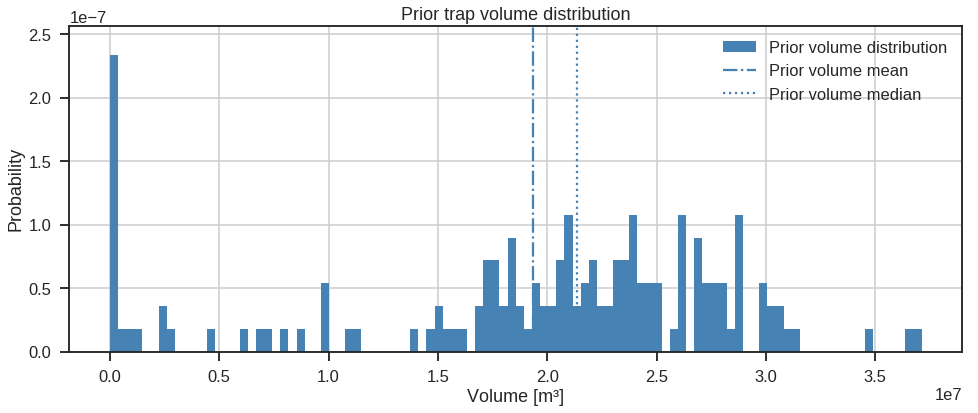

In [79]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(vol_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(vol_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(vol_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [80]:
trap_control_trace

array([1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1.,
       1., 3., 4., 1., 2., 2., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 3., 1., 1., 2., 1., 1., 1., 1., 2., 3., 1., 3., 1., 2., 2.,
       1., 1., 4., 1., 1., 1., 1., 1., 2., 1., 1., 2., 2., 1., 1., 1., 2.,
       3., 1., 2., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 2., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2., 3., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 2., 1., 2.,
       3., 1., 4., 2., 2., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 3.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.])

In [92]:
# COUNT TRAP CONTROL OCCURRENCES
uniques, counts = np.unique(trap_control_trace, return_counts=True)
counts = np.round((counts/iterations)*100)

labels = ('UNCLEAR', 'SPILL POINT', 'LEAK UNDER', 'LEAK OVER', 'STRAT')
trap_base = dict(zip(labels, [0,0,0,0,0]))
trap_controls = dict(zip(labels, counts))

In [93]:
counts

array([73., 19.,  6.,  2.])

In [119]:
interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
lith_block, fault_block = gp.compute_model(interp_data)

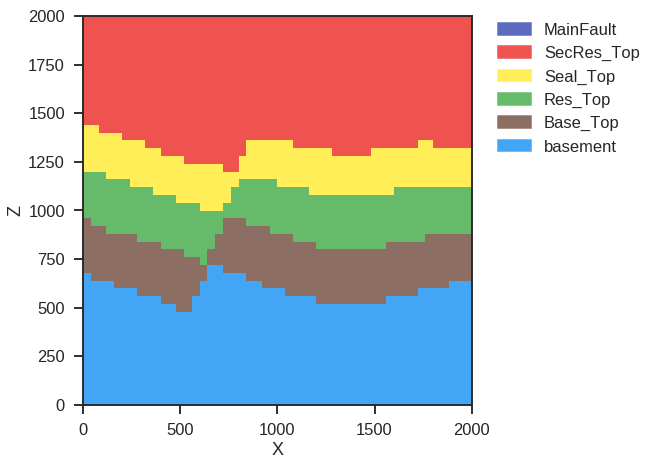

In [120]:
gp.plotting.plot_section(geo_data, lith_block[0], 25, plot_data=False)

SPILL POINT COORDINATES: [1360.          880.          786.50054932]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 8
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 19
Maximum trap volume: 22592000.0 m³


(22592000.0, 2.5, 2)

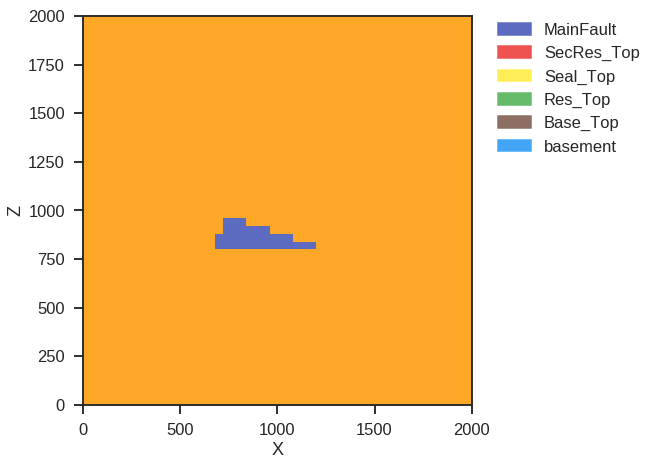

In [121]:
trap_analysis_post(lith_block, fault_block, print_figures=True)

In [95]:
post.db.trap_analysis[:][:10]

array([[2.43840000e+07, 1.83333333e+00, 1.00000000e+00],
       [2.41280000e+07, 2.00000000e+00, 1.00000000e+00],
       [2.88640000e+07, 6.00000000e-01, 1.00000000e+00],
       [2.38080000e+07, 2.50000000e+00, 1.00000000e+00],
       [2.08000000e+07, 2.20000000e+00, 1.00000000e+00],
       [2.79040000e+07, 2.50000000e+00, 1.00000000e+00],
       [1.88800000e+07, 2.12500000e+00, 1.00000000e+00],
       [2.82240000e+07, 1.85714286e+00, 1.00000000e+00],
       [2.94400000e+06, 5.00000000e-01, 2.00000000e+00],
       [2.36800000e+07, 7.00000000e-01, 1.00000000e+00]])

In [103]:
post.change_input_data??

In [102]:
interp_data.update_interpolator??

SPILL POINT COORDINATES: [1320.          880.          748.83117676]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 24
Maximum trap volume: 23872000.0 m³
SPILL POINT COORDINATES: [1360.          880.          617.02407837]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: []
SSF = 600.0 / 280.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 26
Maximum trap volume: 24576000.0 m³
SPILL POINT COORDINATES: [1360.          880.          631.35803223]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 600.0 / 360.0 = 1.6666666666666667
SSF in

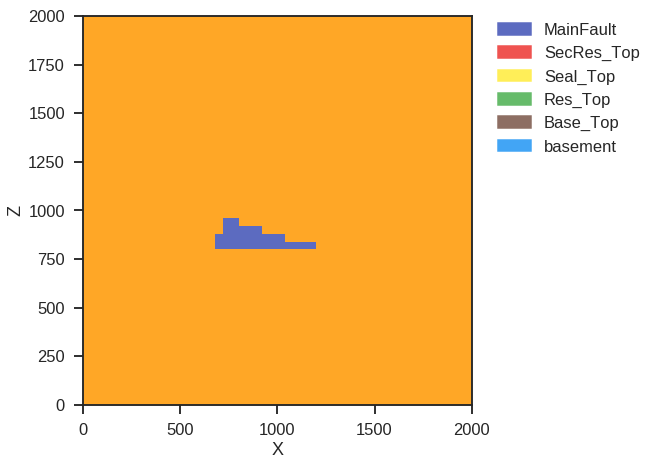

In [96]:
vol, SSF, tc = [],[],[]
for i in np.arange(0,5):#post.db.input_data.length()):
    post.change_input_data(interp_data, i)
    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
    lith_sol, fault_sol = gp.compute_model(interp_data)
    #gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 25, plot_data=True)
    v,s,c = trap_analysis_post(lith_sol, fault_sol, print_figures=True)
    vol.append(v)
    SSF.append(s)
    tc.append(c)

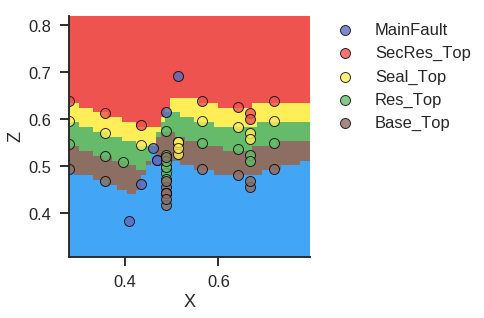

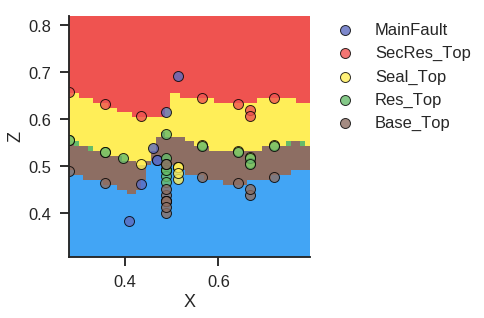

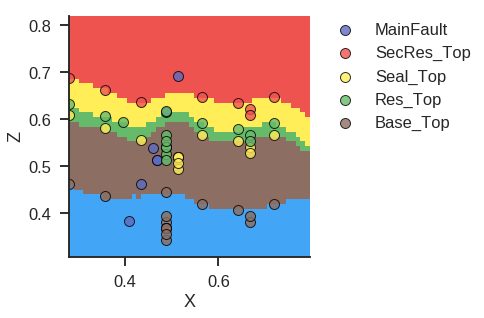

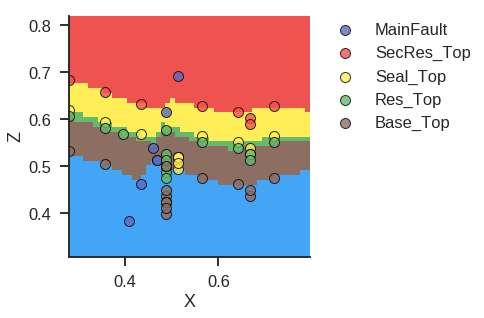

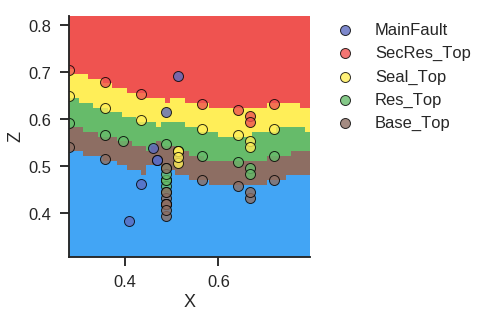

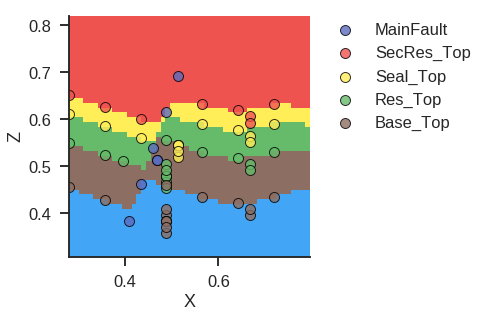

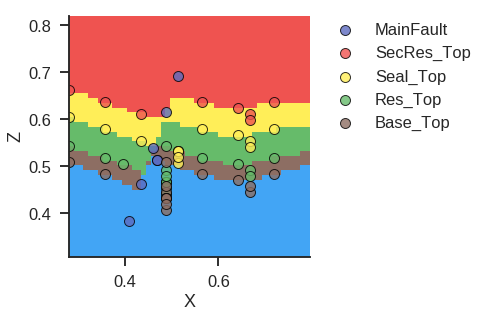

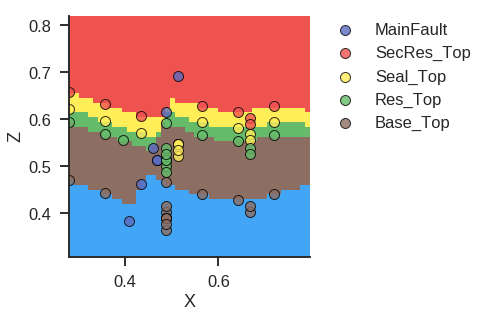

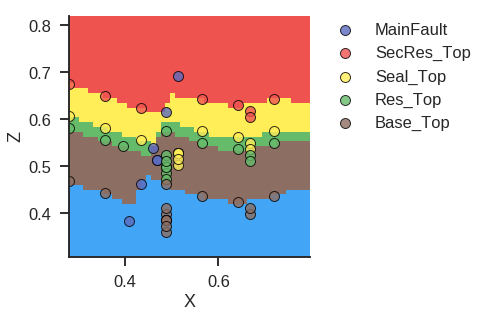

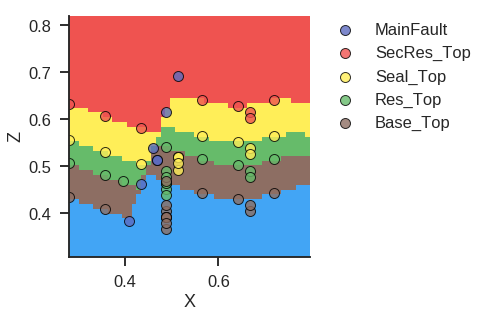

In [66]:
for i in np.arange(post.db.input_data.length()):
    post.change_input_data(interp_data, i)
    lith_sol, fault_sol = gp.compute_model(interp_data)
    gp.plotting.plot_section(interp_data.geo_data_res, lith_sol[0], 25, plot_data=True)

# POSTERIOR MODEL

In [ ]:
### LIKELIHOOD FUNCTIONS

# THICKNESS LIKELIHOODS
#Additional information, updating with likelihoods
std1 = 30
std2 = 30
std3 = 30

@pymc.stochastic(trace=True)
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(thicknesses[2], 150., 1./np.square(std1))

@pymc.stochastic(trace=True)
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(thicknesses[1], 350., 1./np.square(std2))

@pymc.stochastic(trace=True)
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(thicknesses[0], 250., 1./np.square(std3))


# SSF LIKELIHOOD
@pymc.stochastic(trace=True)
def SSF_likelihood(value = 0, SSF=structural_model[1]):
    return pymc.normal_like(SSF, 3, 1./np.square(0.3))


# JUXTAPOSITION AREA LIKELIHOOD (MOT USED)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [65]:
iterations = 50

In [66]:
params = [input_data, thicknesses, gempy_model, *lith_Z_modifier, fault_Z_modifier]
model = pymc.Model(params)
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [67]:
dbname="trapmodel_lithTH"+str(lith_unc_stds)+"_offset"+str(std_offset)+"_"+str(iterations)+"iterations"+".hdf5"

In [68]:
RUN = pymc.MCMC(model, db="hdf5", dbname=dbname)

In [69]:
RUN.sample(iter=iterations)

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [---              10%                  ] 5 of 50 complete in 0.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [------           16%                  ] 8 of 50 complete in 1.3 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [--------         22%                  ] 11 of 50 complete in 1.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------      30%                  ] 15 of 50 complete in 2.4 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [--------------   38%                  ] 19 of 50 complete in 2.9 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------46%                  ] 23 of 50 complete in 3.4 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------56%-                 ] 28 of 50 complete in 4.0 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------66%-----             ] 33 of 50 complete in 4.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------74%--------          ] 37 of 50 complete in 5.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------82%-----------       ] 41 of 50 complete in 5.7 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------90%--------------    ] 45 of 50 complete in 6.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------100%-----------------] 50 of 50 complete in 6.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------100%-----------------] 50 of 50 complete in 6.9 sec

In [ ]:
likelihoods = "thickness" # choose which likelihoods to use: "thickness", "SSF" or "both"

if likelihoods == "thickness":
    # Model inclucing only thickness likelihoods
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
elif likelihoods == "SSF":    
    # Model including only SSF likelihood
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, SSF_likelihood])
elif likelihoods == "both":
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, 
                          sec_res_th_likelihood, SSF_likelihood])
else:
    print("Did not understand which likelihood functions to use.")

In [ ]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

In [ ]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

In [ ]:
#CUSTOM LOSS FUNCTION
estimates_s = np.arange(0,60000000, 10000)

# weight factors
o = 1.25
o_f = 2
u_f = 1.5

# risk factor range
risks_s = np.arange(0.5, 1.6, 0.25)


In [ ]:
dm.expected_loss_plot(estimate_range=estimates_s,
                      true_s=max_volume_trace,
                      risk_range=risks_s,o=o,o_f=o_f,u_f=u_f)

In [ ]:
iterations=20

In [ ]:
M_L = pymc.MCMC(model_L)
#M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-050_10-400_40_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=0)

In [ ]:
#M_L.db.commit()
#M_L.db.close()

In [ ]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
interp_trace_L = M_L.trace('interp_unc')[:]
#over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

structural_model_trace_L = M_L.trace('structural_model')[:]
max_volume_trace_L = structural_model_trace_L[:,2]
SSF_trace_L = structural_model_trace_L[:,4]
trap_control_trace_L = structural_model_trace_L[:,5]

In [ ]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

In [ ]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace_L, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace_L, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace_L, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace_L, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace_L, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace_L*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace_L, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace_L, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

In [ ]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

In [ ]:
figsize(20,10)
fig, ax = plt.subplots(1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,resolution/2,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [ ]:
dm.expected_loss_plot(estimate_range=estimates_s, true_s=max_volume_trace_L,
                     risk_range=risks_s, o=o, o_f=o_f, u_f=u_f)

In [ ]:
# FOR EXPORTING TO USE IN PARAVIEW:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/14_11-TRAP_100iterUNC_PRIORonly_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/14_11-LITH_100iterUNC_PRIORonly_%s" % (counter))

In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()